<a href="https://colab.research.google.com/github/ragini-dwivedi/Yelp-Dataset/blob/main/Yathukulan/alsfactorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null #sets up jdk 8

In [ ]:
!wget -q https://mirrors.sonic.net/apache/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz #downloads apache spark

In [ ]:
!tar xf spark-2.4.7-bin-hadoop2.7.tgz #unpacks spark files

In [ ]:
!pip install -q findspark #installs spark

In [ ]:
#importing OS and setting up the java and spark environments (https://colab.research.google.com/github/asifahmed90/pyspark-ML-in-Colab/blob/master/PySpark_Regression_Analysis.ipynb)
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

In [ ]:
#initializing spark
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
import csv
import pandas as pd
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
 
#ml
# from pyspark.ml.recommendation import ALS
# from pyspark.ml.evaluation import RegressionEvaluator
# from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

from pyspark import SparkContext

In [ ]:
spark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/Shareddrives/Yelp_dataset/restuarant_reviews/by_city/'

/content/drive/Shareddrives/Yelp_dataset/restuarant_reviews/by_city


In [ ]:
ls

hashed_reviews_ph.csv                    modelinput_reviews_tr.csv
modelinput_phoenix_restaurant_stars.csv  reviews_allcities.csv
modelinput_reviews_allcities.csv         reviews_lv.csv
modelinput_reviews_lv.csv                reviews_ph.csv
modelinput_reviews_ph.csv                reviews_tr.csv


In [ ]:
def findALS(path,rank=15,numIterations=15,train_ratio=0.9):

  stars = spark.read.csv(path,inferSchema=True, header =True)#.limit(100000)

  ratio = [train_ratio,1-train_ratio]
  train, test = stars.randomSplit(ratio)

  train_rdd = train.rdd.map(lambda x: Rating(int(x[0]), int(x[1]), float(x[2])))
  test_rdd = test.rdd.map(lambda p: (p[0],p[1]))

  #mlib
  model = ALS.train(train_rdd,rank=rank,iterations = numIterations)

  preds = model.predictAll(test_rdd).map(lambda r: ((r[0], r[1]), r[2]))

  ratesAndPreds = test.rdd.map(lambda r: ((r[0], r[1]), r[2])).join(preds)
  MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean() 

  RMSE = sqrt(MSE)
  
  return RMSE, model, ratesAndPreds


In [ ]:
dataset =['Toronto','Las Vegas', 'Phoenix', 'All']
RMSE_vals = []

In [ ]:
%%time
RMSE, model, preds = findALS('/content/drive/Shareddrives/Yelp_dataset/restuarant_reviews/by_city/modelinput_reviews_tr.csv')
RMSE_vals.append(RMSE)
print('RMSE:',RMSE)

RMSE: 1.8546740029744102
CPU times: user 59 ms, sys: 13.3 ms, total: 72.4 ms
Wall time: 29.2 s


In [ ]:
%%time
RMSE, model, preds =findALS('/content/drive/Shareddrives/Yelp_dataset/restuarant_reviews/by_city/modelinput_reviews_lv.csv')
RMSE_vals.append(RMSE)
print('RMSE:',RMSE)

RMSE: 2.196246183981309
CPU times: user 60.9 ms, sys: 14.9 ms, total: 75.8 ms
Wall time: 1min 35s


In [ ]:
%%time
RMSE, model, preds =findALS('/content/drive/Shareddrives/Yelp_dataset/restuarant_reviews/by_city/modelinput_reviews_ph.csv')
RMSE_vals.append(RMSE)
print('RMSE:',RMSE)

RMSE: 2.339859024644972
CPU times: user 56 ms, sys: 13.2 ms, total: 69.2 ms
Wall time: 35.3 s


In [ ]:
%%time
RMSE, model, preds =findALS('/content/drive/Shareddrives/Yelp_dataset/restuarant_reviews/by_city/modelinput_reviews_allcities.csv')
RMSE_vals.append(RMSE)
print('RMSE:',RMSE)

RMSE: 2.137879022154073
CPU times: user 94.1 ms, sys: 16.9 ms, total: 111 ms
Wall time: 5min 19s


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


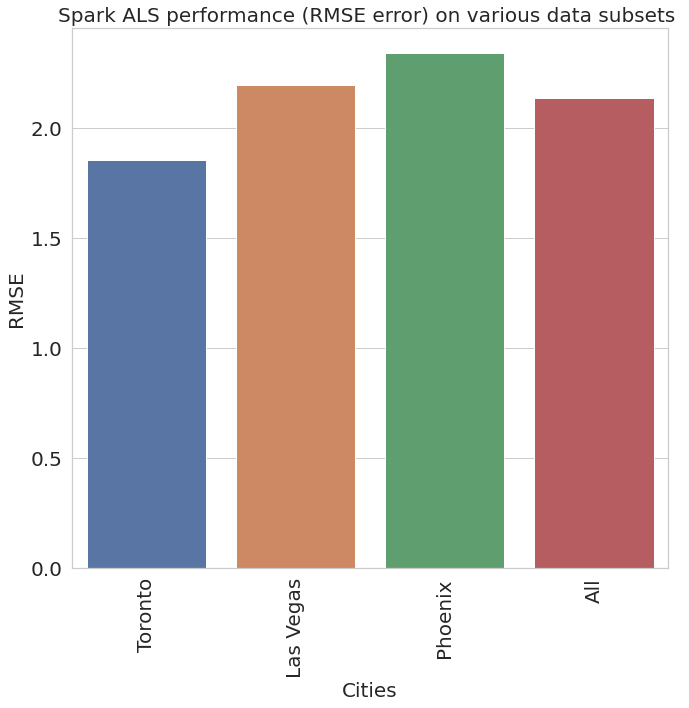

In [ ]:
plt.figure(figsize=(10,10))
#plt.bar(dataset, RMSE_vals)
sns.set(style="whitegrid")
sns.barplot(dataset,RMSE_vals)
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.title('Spark ALS performance (RMSE error) on various data subsets ', fontsize=20)
plt.xlabel('Cities',fontsize=20)
plt.ylabel('RMSE',fontsize=20)
plt.tight_layout()

In [ ]:
preds

PythonRDD[6349] at RDD at PythonRDD.scala:53

In [ ]:
%%time
preds_df = preds.toDF()

CPU times: user 19.7 ms, sys: 2.51 ms, total: 22.2 ms
Wall time: 897 ms


In [ ]:
preds_df.show()

+------------+--------------------+
|          _1|                  _2|
+------------+--------------------+
|  [0, 32626]|[1, 1.01429689595...|
| [22, 41580]|[4, 4.18271528669...|
| [65, 25253]|[5, 2.34801152103...|
|  [73, 7117]|[5, 3.25156513481...|
|  [89, 7533]|[5, 1.00721885584...|
|[138, 13556]|[1, 5.02461707124...|
|[138, 27576]|[4, 3.11045259270...|
|  [155, 623]|[2, 2.86096097138...|
|[155, 21115]|[3, 2.52258194424...|
|[155, 22651]|[3, 1.91052947523...|
|[160, 63406]|[1, 2.90317647915...|
|[174, 34208]|[3, 1.24899217011...|
|[200, 11594]|[5, 4.42650788442...|
|[261, 32281]|[4, 3.65124682133...|
|[285, 30209]|[5, 2.75680314735...|
|[364, 34522]|[4, 1.33168646672...|
|[405, 31737]|[5, 4.79951860199...|
|[520, 32998]|[4, 4.11005172732...|
|[525, 33413]|[5, 1.36583608909...|
|[557, 37941]|[4, 2.56000603347...|
+------------+--------------------+
only showing top 20 rows



In [ ]:
preds_df = preds_df.withColumnRenamed("_1", "(user,business)combinations")\
       .withColumnRenamed("_2", "predicted_ratings")

In [ ]:
preds_df.sort("(user,business)combinations")

DataFrame[(user,business)combinations: struct<_1:bigint,_2:bigint>, predicted_ratings: double]

In [ ]:
preds_df.show()

+---------------------------+--------------------+
|(user,business)combinations|   predicted_ratings|
+---------------------------+--------------------+
|             [1339720, 730]|  3.6308952691851992|
|             [38926, 22730]|   3.611104046733243|
|             [38926, 18189]|   4.426377511166564|
|             [38926, 47717]|  3.4630601820484723|
|           [1247824, 27842]|  0.7874708154947845|
|           [1373598, 30906]|0.010776420195698612|
|            [333678, 16136]|  1.5755027204845797|
|             [333678, 2066]|  0.6870315894350281|
|            [806480, 40084]|   2.210130458835182|
|             [409494, 7454]|  1.2501406344427586|
|            [409494, 61707]|  1.7572291504259272|
|            [452974, 38888]|   2.706965070799096|
|            [282554, 46475]|   3.877988168394535|
|           [1309222, 57174]|   1.758008207295709|
|           [1209850, 49844]|   5.838054770981977|
|           [1209850, 35606]|  3.1266886749934955|
|           [1380892, 39829]|  